# Practical 03 - RRT Algorithm

Note: CoLab is not supported for this week. For the online version, please visit https://mybinder.org/v2/gh/tianleimin/ECE4078_Practical_2021/main and proceed as if running locally. **Remember to download a copy of the notebook when you are done if running online. Otherwise, you will lose the notebook once you close the tab.**

In [1]:
%matplotlib notebook

import math
import random
import os
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import time

# Import dependencies and set random seed
seed_value = int(time.time())#5
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)


from helper_james import *
from util.DatasetHandler import InputReader

global ani

beginning fruit path iteration


<IPython.core.display.Javascript object>


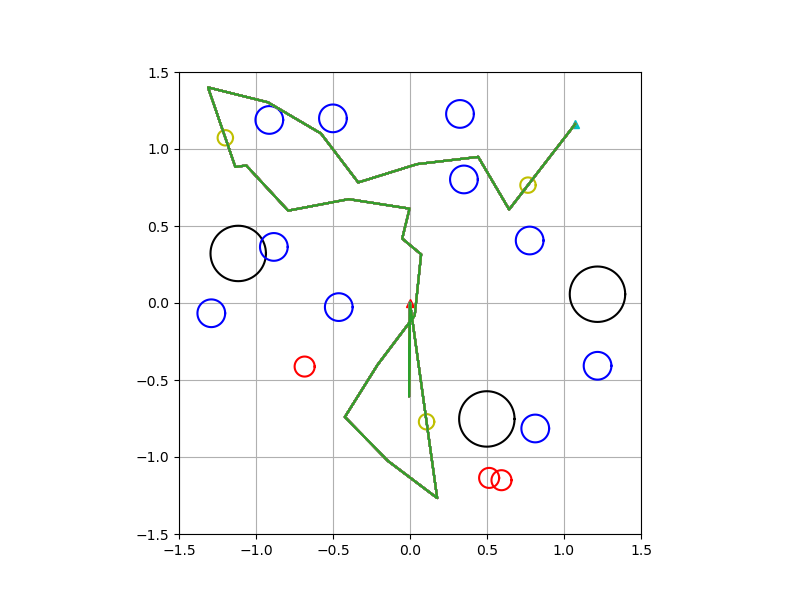

In [2]:
## obstacle list complete, we now want to generate pairings of people and apples, and mark which lemons need to be moved

#required_distance = 0.5
#goal_error = 0.05

## dont move apples that are already in place, find these pairs

#people_done = []
#apples_done = []
#pairs = []


#for person_idx, person in enumerate(person_gt):
#    for apple_idx, apple in enumerate(apple_gt):
#        if apple[0] in apples_done:
#            continue
#        elif np.hypot(apple[0] - person[0], apple[1] - person[1]) < (required_distance - goal_error):
#            #if this is the case, an apple is within range of a person, including some consideration of error
#            apples_done.append(apple[0])
#            people_done.append(person[0])
#            pairs.append((person, apple))
#            
#people_not_done = [n for n in person_gt if n[0] not in people_done]
#apples_not_done = [n for n in apple_gt if n[0] not in apples_done]

#print(people_not_done, "\n", apples_not_done)

# assemble all combinations of people and apples who are not matched

#unmatched_pairs = []
#unmatched_person_ids = [n for n in person]

#for person in people_not_done:
#    for apple in apples_not_done:
#        unmatched_pairs.append((person, apple, np.hypot(apple[0] - person[0], apple[1] - person[1])))

#print(unmatched_pairs)

# pick combination of unmatched pairs which minimises travel distance


#list1 = ["a", "b", "c"]
#list2 = [1, 2]

#all_combinations = [list(zip(each_permutation, list2)) for each_permutation in itertools.permutations(list1, len(list2))]
#print(all_combinations)



## something new.

reader = InputReader('lab_output/')

taglist, markers, P = reader.read_slam()
objects = reader.read_objects()

r_true_apple = 0.075
r_true_lemon = 0.06
r_true_person = 0.19
r_true_marker = 0.1

scale = -0.01

r_true_apple += scale
r_true_lemon += scale
r_true_person += scale
r_true_marker += scale

radii = [r_true_apple, r_true_lemon, r_true_person, r_true_marker]

all_obstacles = []

for i in range(3):
    for entry in objects[i]:
        all_obstacles.append(CircleT(entry[0], entry[1], radii[i], i))

        
for i in range(int(markers.size/2)):
    all_obstacles.append(CircleT(markers[0, i], markers[1, i], r_true_marker, 3))


lemons_not_done = objects_not_done(objects[0], objects[1], objects[2])

initial_point = [0, 0]

instructions, length, log = generate_fruit_path([], [], list(objects[1]), all_obstacles, initial_point, 20)

#print(path)
#print(log)
#print(wp_type)

#A = np.array([1.0, 1.2])
#B = np.array([1.1, 1.1])


#print(push_lemon_x(A, B, 0.5, abs_world_bounds = 1.2))

#print(straightline_intermediate_points(p1, p2))
#rrt = RRT(start=[-1, -1], goal=[1, 1], width=1.4, height=1.4, obstacle_list=all_obstacles, expand_dis=0.3 , path_resolution=0.04, max_points=50)

#print(rrt.planning())
 # 
ani_path = animate_path_x(np.array([instr.point for instr in instructions]), (-1.5, 1.5), (-1.5, 1.5), all_obstacles)



display(HTML("<style>.container { width:100% !important}</style>"))